The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using project root: C:\My data\A.change jobs\data_science_practice
==========分析全部資料==========

--- 正在執行迴歸分析 ---
應變數 (Y): 街區房屋價值中位數(USD)
自變數 (X): ['街區房間總數', '街區臥室總數', '街區人口總數', '街區家庭戶數', '街區家庭收入中位數(USD)']

--- 正在把迴歸係數相關資訊匯出成 Excel 檔案 ---

✅ 成功匯出結果至： data/results/迴歸係數相關資訊_全部資料_20251224_v1.xlsx

--- 正在計算預測值並匯出 Excel 檔案 ---

✅ 成功匯出結果至： data/results/迴歸預測結果_全部資料_20251224_v1.xlsx

--- 透過殘差圖檢查模型可靠性 ---


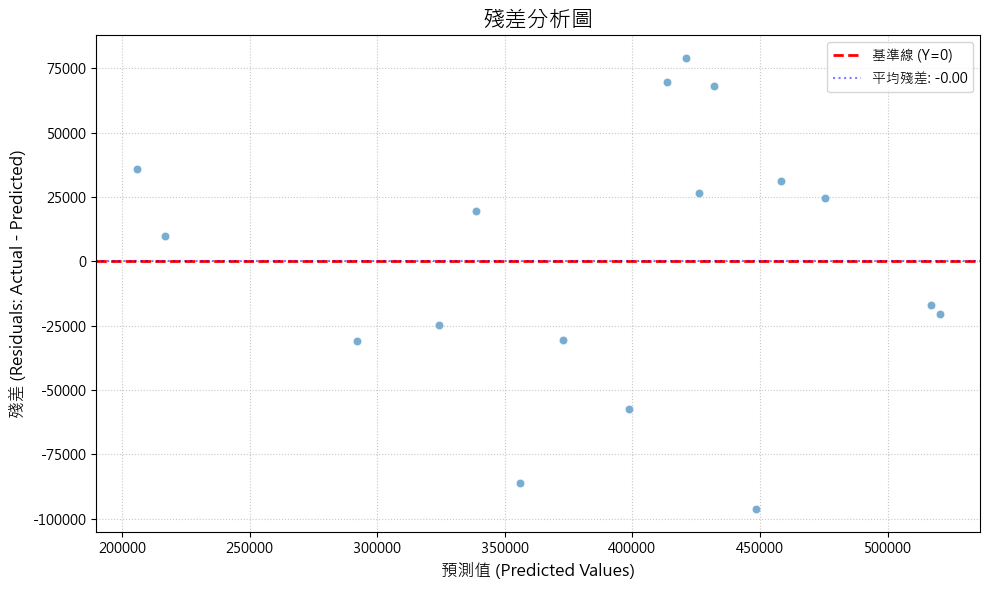


--- 正在執行迴歸分析 ---
應變數 (Y): 街區房屋價值中位數(USD)
自變數 (X): ['街區房間總數', '街區臥室總數', '街區人口總數', '街區家庭戶數', '街區家庭收入中位數(USD)']

--- 正在把迴歸係數相關資訊匯出成 Excel 檔案 ---

✅ 成功匯出結果至： data/results/迴歸係數相關資訊_過濾極端值資料_20251224_v1.xlsx

--- 正在計算預測值並匯出 Excel 檔案 ---

✅ 成功匯出結果至： data/results/迴歸預測結果_過濾極端值資料_20251224_v1.xlsx

--- 透過殘差圖檢查模型可靠性 ---


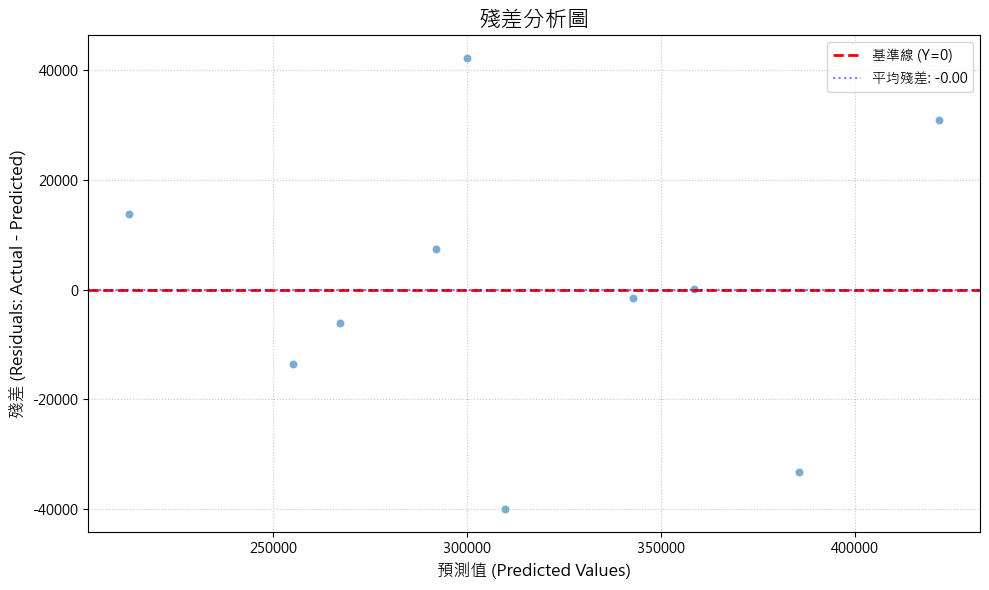

In [6]:
%load_ext autoreload
%autoreload 2
from path_setup import setup_project_root
root = setup_project_root()

import pandas as pd
import numpy as np
from datetime import datetime
from typing import List, Dict, Any

# Local modules
from etl_showcase.infrastructure.utils.file_utils import (
    dataframe_to_excel,
)
from etl_showcase.infrastructure.statistics.regression_utils import (
    run_multivariate_regression,
    display_regression_coefficients,
    get_regression_coefficients,
    generate_regression_predictions,
)
from etl_showcase.infrastructure.reporting.regression_visualizer import (
    plot_residual_analysis,
)


def generate_simulated_data(
    index_column: str,
    is_outlier_column: str,
    x_columns: List[str],
    y_column: str,
    num_samples: int = 200,
) -> pd.DataFrame:
    """生成模擬的房屋數據，用於演示迴歸分析。"""
    print(f"--- 正在生成 {num_samples} 筆模擬資料 ---")

    # 模擬自變數 (X variables)
    population = np.random.randint(500, 50000, num_samples)
    households = population * np.random.uniform(0.3, 0.45, num_samples)
    total_rooms = population * np.random.uniform(1.0, 3.0, num_samples)
    total_bedrooms = total_rooms * np.random.uniform(0.15, 0.25, num_samples)
    median_income = np.random.randint(25000, 150000, num_samples) 

    # 模擬應變數 (Y variable) - 房屋價值中位數
    # 假設房屋價值強烈受收入影響，並保持其他變數的影響
    median_house_value = (
        50000  # 基礎價值
        + median_income * 2.5 # 收入每增加1元，房價增加2.5元 (強烈影響)
        + total_rooms * 50  # 房間越多越貴
        + total_bedrooms * 200  # 臥室數量影響更大
        + (population / 1000) * 500  # 人口密度影響
        + np.random.normal(0, 40000, num_samples)  # 隨機噪音
    )
    # 確保價值不會低於零
    median_house_value[median_house_value < 10000] = 10000

    # --- 新增欄位邏輯 ---
    # 1. 索引欄位 (1 到 N)
    indices = np.arange(1, num_samples + 1)
    
    # 2. 是否為房價極端值 (隨機選取 "正常值" 或 "極端值")
    outlier_status = np.random.choice([False, True], size=num_samples)

    data = pd.DataFrame({
        index_column: indices,
        y_column: median_house_value,
        x_columns[0]: total_rooms.astype(int),
        x_columns[1]: total_bedrooms.astype(int),
        x_columns[2]: population,
        x_columns[3]: households.astype(int),
        x_columns[4]: median_income,
        is_outlier_column: outlier_status
    })

    return data

def regression_analysis(
    data: pd.DataFrame,
    index_column: str,
    x_columns: List[str],
    y_column: str,
    result_file_postfix: str,
):   
    # 1. 執行迴歸
    regression_results = run_multivariate_regression(
        data = data, 
        x_columns = x_columns,
        y_column = y_column,
    )

    # 2. 匯出迴歸係數 Excel 檔案
    print(f"\n--- 正在把迴歸係數相關資訊匯出成 Excel 檔案 ---")
    coef_df = get_regression_coefficients(regression_results)
    dataframe_to_excel(
        df = coef_df,
        file_path = f'data/results/迴歸係數相關資訊_{result_file_postfix}.xlsx',
        keep_index = True,
    )   

    # 3. 匯出預測值 Excel 檔案
    print(f"\n--- 正在計算預測值並匯出 Excel 檔案 ---")
    predictions_df = generate_regression_predictions(
        df_original = data, 
        results = regression_results,
        index_column = index_column,
        x_columns = x_columns,
        y_column = y_column,
    )
    dataframe_to_excel(
        df = predictions_df,
        file_path = f'data/results/迴歸預測結果_{result_file_postfix}.xlsx',
    )

    # 4. 畫殘差圖供檢查模型可靠性
    print(f"\n--- 透過殘差圖檢查模型可靠性 ---")
    plot_residual_analysis(
        df = predictions_df, 
        true_col = 'true values', 
        pred_col = 'predicted values',
    )

# --- 主程式執行區塊 ---
if __name__ == "__main__":
    # 定義共用變數
    index_column = '索引'
    is_outlier_column = '是否為房價極端值'
    y_column = '街區房屋價值中位數(USD)'
    x_columns = ['街區房間總數', '街區臥室總數', '街區人口總數', '街區家庭戶數', '街區家庭收入中位數(USD)']
    
    # 1. 載入或生成資料
    try:
        # 從實際 Excel 檔案載入
        # data = pd.read_excel('data/raw/房價資料範例.xlsx')
        
        # 模擬資料
        data = generate_simulated_data(
            index_column = index_column,
            is_outlier_column = is_outlier_column,
            x_columns = x_columns,
            y_column = y_column,
        )
    except FileNotFoundError:
        print("找不到指定的 Excel 檔案，請檢查路徑。")
        exit()
    except Exception as e:
        print(f"載入或處理資料時發生錯誤: {e}")
        exit()

    # 2. 分別把全部資料、過濾極端值資料 各進行一次迴歸分析
    date_str = datetime.now().strftime("%Y%m%d")
    print('==========分析全部資料==========')
    regression_analysis(
        data = data,
        index_column = index_column,
        x_columns = x_columns,
        y_column = y_column,
        result_file_postfix = f'全部資料_{date_str}_v1',
    )  
    # print('==========分析過濾極端值資料==========')
    filtered_data = data[data[is_outlier_column] == False].copy()
    regression_analysis(
        data = filtered_data,
        index_column = index_column,
        x_columns = x_columns,
        y_column = y_column,
        result_file_postfix = f'過濾極端值資料_{date_str}_v1',
    )  